# Reinforcement Learning Final Project 

Welcome to your Reinforcement Learning project focused on developing an RL agent capable of playing chess at a strategic level. Chess has long been considered a benchmark for measuring AI capabilities, and this project aims to leverage the power of RL to create an intelligent agent that can make optimal decisions in complex chess positions. By combining the principles of reinforcement learning with the rich strategic domain of chess, you will explore new approaches to create the most effective chess player.

## Project Objectives:

* Train an RL agent to play chess: The primary objective of this project is to develop an RL agent that can play chess at a high level of proficiency. The agent should be capable of evaluating chess positions and making strategic decisions.

* Optimize decision-making using RL algorithms: Explore different RL algorithms, as seen in class, to train the agent. Compare and analise their effectiveness in learning and decision-making capabilities in the context of chess.

* Use a challenging chess environment: Use a comprehensive environment for the agent to interact with, representing the rules and dynamics of chess. This environment will provide a realistic and challenging setting for the agent's training and evaluation.

* Evaluate and benchmark performance: Assess the performance of the RL agent against different benchmarks from existing chess engines. You will compare your agent's performance to established chess engines to measure progress and identify areas for improvement.


### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.

* Enhance interpretability and analysis: Develop methods to analise the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.

## Let's Play Chess! 

As you know [Chess](https://en.wikipedia.org/wiki/Chess) is a board game for two players, called White and Black, each controlling an army of chess pieces in their color, with the objective to checkmate the opponent's king.

Chess is an abstract strategy game that involves no hidden information and no use of dice or cards. It is played on a chessboard with 64 squares arranged in an eight-by-eight grid. At the start, each player controls sixteen pieces: one king, one queen, two rooks, two bishops, two knights, and eight pawns. White moves first, followed by Black. Checkmating the opponent's king involves putting the king under immediate attack (in "check") whereby there is no way for it to escape.


![](Images/CHESS_MOVES.PNG)

* The king moves one square in any direction. There is also a special move called castling that involves moving the king and a rook. The king is the most valuable piece — attacks on the king must be immediately countered, and if this is impossible, the game is immediately lost.
* A rook can move any number of squares along a rank or file, but cannot leap over other pieces. Along with the king, a rook is involved during the king's castling move.
* A bishop can move any number of squares diagonally, but cannot leap over other pieces.
* A queen combines the power of a rook and bishop and can move any number of squares along a rank, file, or diagonal, but cannot leap over other pieces.
* A knight moves to any of the closest squares that are not on the same rank, file, or diagonal. (Thus the move forms an "L"-shape: two squares vertically and one square horizontally, or two squares horizontally and one square vertically.) The knight is the only piece that can leap over other pieces.
* A pawn can move forward to the unoccupied square immediately in front of it on the same file, or on its first move it can advance two squares along the same file, provided both squares are unoccupied (black dots in the diagram). A pawn can capture an opponent's piece on a square diagonally in front of it by moving to that square (black crosses). It cannot capture a piece while advancing along the same file. A pawn has two special moves: the en passant capture and promotion.

### Imports

In [1]:
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from collections import deque, defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
import random
from tensorflow import keras

#### The agent receives a reward of +1 when the white player makes a winning move, and a reward of -1 when the black player makes a winning move. 

All other rewards are zero.

### Evaluationg your agent with [Stockfish](https://github.com/zhelyabuzhsky/stockfish)

In order to have a good enough idea that our agent is actually playing well we need a benchmarkable opponent.

As such we need to install stockfish a free and open-source chess engine. Stockfish has consistently ranked first or near the top of most chess-engine rating lists and, as of April 2023, is the strongest CPU chess engine in the world.

`pip install stockfish`


In [2]:
from stockfish import Stockfish

StockFish has a python api as seen above, nevertheless the engine still needs to be downloaded [here](https://stockfishchess.org/download/) and used in the path.

NOTE: You were given an engine already in moodle, nevertheless different computer systems (Windows, Mac, Ubuntu) might require other Stockfish engines.

In [3]:
# David
Stockfish_path = "C:/Users/David/Desktop/Nova IMS/2º semestre/Reinforcement Learning/project/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

# Ready to Play Chess?

In [4]:
# Set the initial state
state = chess.Board()

# Set the counter for the number of steps
counter = 0

# Define the Deep Q-Network (DQN) Model
input_shape = (8, 8, 12)  # Assuming a chess board representation with channels for each piece type
action_space_size = 4096

model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(action_space_size, activation='linear'))

model.compile(optimizer='adam', loss='mse')

class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        self.agent_plays = []
    
    def add(self, state, action, reward, next_state):
        experience = (state, action, reward, next_state)
        self.buffer.append(experience)
        
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)
    
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        states, actions, rewards, next_states = zip(*[self.buffer[i] for i in batch])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

replay_buffer = ReplayBuffer(max_size=100000)

def preprocess_state(board):
    """
    Preprocess the chess board state.

    Args:
        board (chess.Board): The chess board.

    Returns:
        np.array: The preprocessed state array.
    """
    state_array = np.zeros((8, 8, 12))  # Reshape to match expected input shape
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            piece_type = piece.piece_type
            color = int(piece.color)
            channel = piece_type - 1 + color * 6
            row = i // 8
            col = i % 8
            state_array[row, col, channel] = 1
    return state_array


def select_action(board, dqn_model, current_step, total_steps):
    # Calculate the updated epsilon value based on the current step and total steps
    epsilon = max(0.1, 1.0 - current_step / total_steps)

    # Use epsilon-greedy exploration
    if np.random.rand() < epsilon:
        return np.random.choice(list(board.legal_moves))
    else:
        if agent_plays:
            # Use agent's recorded plays if available
            return agent_plays.pop(0)
        else:
            state_array = preprocess_state(board)
            state_input = np.array([state_array])
            q_values = dqn_model.predict(state_input)[0]
            valid_moves = list(board.legal_moves)
            valid_move_indices = [move_to_index(move) for move in valid_moves]
            valid_q_values = [q_values[i] for i in valid_move_indices]
            return valid_moves[np.argmax(valid_q_values)]


def move_to_index(move):
    """
    Convert a chess move to an index.

    Args:
        move (chess.Move): A chess move.

    Returns:
        int: The index corresponding to the move.
    """
    return move.from_square * 64 + move.to_square

import chess
import chess.engine
import numpy as np

def generate_episode(stockfish_path, dqn_model, replay_buffer, epsilon):
    engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
    board = chess.Board()
    counter = 0

    while not board.is_game_over():
        state_array = preprocess_state(board)
        state_input = np.array([state_array])

        if board.turn == chess.WHITE:
            # Agent's turn
            if np.random.random() < epsilon:
                # Explore: select a random legal move
                action = np.random.choice(list(board.legal_moves))
            else:
                # Exploit: select action with highest Q-value from DQN
                q_values = dqn_model.predict(state_input)[0]
                valid_moves = list(board.legal_moves)
                valid_move_indices = [move_to_index(move) for move in valid_moves]
                valid_q_values = [q_values[i] for i in valid_move_indices]
                action = valid_moves[np.argmax(valid_q_values)]
            
            # Save agent's play to replay buffer
            replay_buffer.agent_plays.append(action)

            # Execute action and observe next state and reward
            next_state = board.copy()
            next_state.push(action)
            reward = 0  # Set the reward based on the game outcome later

            # Add experience to replay buffer
            replay_buffer.add(state_array, move_to_index(action), reward, preprocess_state(next_state))
        else:
            # Stockfish's turn
            result = engine.play(board, chess.engine.Limit(time=2.0))
            action = result.move
            next_state = board.copy()
            next_state.push(action)
            reward = 0  # Set the reward based on the game outcome later

            # Add experience to replay buffer
            replay_buffer.add(state_array, move_to_index(action), reward, preprocess_state(next_state))

        board.push(action)
        counter += 1

    # Set the reward based on the game outcome
    result = None
    if board.is_checkmate():
        result = 1 if board.turn == chess.BLACK else -1
    elif board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
        result = 0

    engine.quit()
    return result, counter


def deep_q_learning(stockfish_path, dqn_model, replay_buffer, epsilon, batch_size, gamma, num_iterations):
    game_results = []  # To store the results of each game
    moves_per_game = []  # To store the number of moves in each game

    for iteration in range(1, num_iterations + 1):
        result, num_moves = generate_episode(stockfish_path, dqn_model, replay_buffer, epsilon)
        game_results.append(result)
        moves_per_game.append(num_moves)

        # Train the DQN model on the replay buffer
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)
        targets = rewards + gamma * np.amax(dqn_model.predict(next_states), axis=1)
        targets_full = dqn_model.predict(states)
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets

        dqn_model.fit(states, targets_full, epochs=1, verbose=0)
        
        # Update agent's plays for next iteration
        agent_plays = replay_buffer.agent_plays.copy()
        replay_buffer.agent_plays.clear()

        # Print the progress
        print(f"Iteration: {iteration}/{num_iterations} | Result: {result} | Moves: {num_moves}")

    # Plot the game results
    plt.plot(game_results)
    plt.xlabel('Game')
    plt.ylabel('Result')
    plt.title('Game Results')
    plt.show()

    # Create a dataframe with game results and moves per game
    df = pd.DataFrame({'Result': game_results, 'Moves': moves_per_game})

    return df


1/1 [==============================] - 0s 47ms/step
Iteration: 1/2 | Result: -1 | Moves: 26
1/1 [==============================] - 0s 47ms/step
Iteration: 2/2 | Result: -1 | Moves: 30


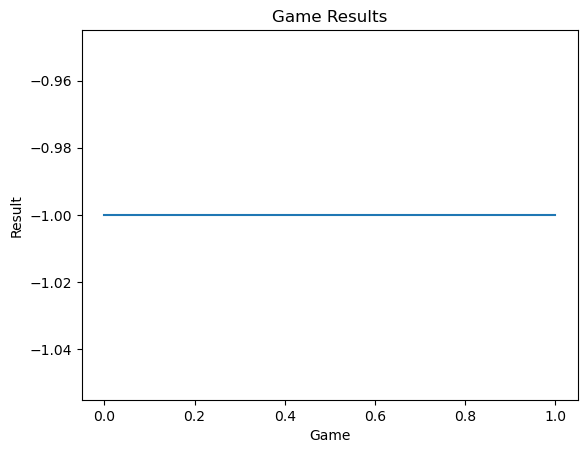

,Result,Moves
0,-1,26
1,-1,30


In [5]:
# Start Deep Q-Learning
deep_q_learning(Stockfish_path, model, replay_buffer, epsilon=0.1, batch_size=4, gamma=0.9, num_iterations=2)


## Deep Q-Learning algorithm for playing chess. 

- The **ReplayBuffer** class is defined, which is used to store and sample experiences for training the Deep Q-Network (DQN) model. The replay buffer has a maximum size defined by the max_size parameter, and new experiences are added using the add method. If the buffer exceeds the maximum size, the oldest experience is removed. Experiences can be sampled using the sample method, which randomly selects a batch of experiences from the buffer.

- The **preprocess_state** function takes a chess board object and converts it into a preprocessed state array. The state array has a shape of (8, 8, 12) to represent the chess board, where each square can have up to 12 channels (6 piece types for each color). The function iterates over each square on the board, retrieves the piece type and color, and assigns a value of 1 to the corresponding channel in the state array.

- The **select_action** function is responsible for selecting an action (move) to play. The exploration_rate starts at epsilon and gradually decreases as the number of steps (counter) increases. This way, the agent starts with a high exploration rate, favoring exploratory actions, and the rate decreases over time, favoring more exploitative actions. The function preprocesses the current board state using the preprocess_state function and then feeds it to the DQN model to get the Q-values for each possible action. The valid moves and their corresponding Q-values are extracted, and either a random move or the move with the highest Q-value is returned.

- The **move_to_index** function converts a chess move object into an index. It uses the from_square and to_square attributes of the move to calculate the corresponding index.

- The **generate_episode** function plays a single episode of chess using the DQN model and a chess engine (Stockfish) to generate moves for the opponent. The function takes the path to the Stockfish engine, the DQN model, the replay buffer, and the exploration rate (epsilon) as input. It initializes the chess board and starts a loop until the game is over. In each iteration, it preprocesses the current board state, selects an action using the select_action function, applies the action to the board, and adds the experience to the replay buffer. If it's the opponent's turn, it uses the Stockfish engine to generate the move. After each move, the function checks if the game is over and assigns a reward based on the game outcome. Finally, it returns the result of the game (1 for win, 0 for draw, -1 for loss) and the number of moves played.

- The **deep_q_learning** function is the main training loop for the DQN model. It takes the Stockfish engine path, the DQN model, the replay buffer, the exploration rate (epsilon), batch size, discount factor (gamma), and the number of training iterations as input. It initializes two lists, game_results and moves_per_game, to store the results and number of moves for each game played. It then iterates for the specified number of iterations and calls the generate_episode function to play a game and obtain the result and number of moves. The result and number of moves are stored in the respective lists. After each game, the DQN model is trained using experiences sampled from the replay buffer. The Q-values of the next states are calculated and used to update the Q-values of the current states and selected actions. The training progress is printed, and the game results are plotted at the end. Finally, a dataframe containing the game results and moves per game is returned.